# **Packet Classification**

This notebook will load the inter-packet timing dataset to attempt to perform packet classification. Both a Support Vector Machine (SVM) and a logisitc regression model will built, trained and evaluated. Please note you will need to generate the inter-packet timing dataset by running the `packet_structures.ipynb` notebook.

## i. Imports

In [1]:
import os
import gc
import sys
import csv
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from imblearn.over_sampling import RandomOverSampler

## **1. Setup**

In [2]:
# Directories
BASEDIR = os.getcwd()
DATADIR = os.path.join(BASEDIR, 'data')
FIGUREDIR = os.path.join(BASEDIR, 'figures')

# Devices
devices = {'ihealth_bpm': 0, 'viatom_wpo': 1, 'vivachek_bgm': 2}

# Colour palette
sns.set_palette('deep')

# GPU settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    gc.collect()
    torch.cuda.empty_cache()
print(f"Device: {device}")

# Initialise random seeds
random_seed = 14
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Training hyperparameters
N_EPOCHS = 50
BATCH_SIZE = 128
N_FEATURES = 1
N_LABELS = 3
LEARNING_RATE = 0.001
K_FOLDS = 5

Device: cpu


In [21]:
# Custom functions
def bold(string):
    """
    Make string bold.

    Args:
        string (str): String to be made bold.

    Returns:
        str: Bold string.

    Raises:
        TypeError: If the input is not a string.
    """
    # Check input type
    if not isinstance(string, str):
        raise TypeError("Input must be a string!")
    
    return "\033[1m" + string + "\033[0m"

    
def accuracy(y_true, y_pred):
    """
    Calculate accuracy of predictions
    compared to ground truth.

    Args:
        y_true (np.array): Array of ground truth y values.
        y_pred (np.array): Array of y value predictions.

    Returns:
        float: Accuracy of predictions.
    """

    return 100 * np.sum(y_pred == y_true) / len(y_true)

def calculate_metrics(y_true, y_pred, model, return_cm=False):
    """
    Calculate performance metrics and 
    plot confusion matrix given predictions 
    and ground truth values.

    Args:
        y_true (np.array): Array of ground truth y values.
        y_pred (np.array): Array of y value predictions.
        model (str): Name of model that generated predictions.
        return_cm (Bool): Boolean determining if confusion matric data is returned.

    Returns:
        float: Total model accuracy.
        DataFrame: DataFrame of groupwise performance metrics.
        DataFrame: Confusion matrix data (optional).
    """
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in devices],
                         columns = [c for c in devices])
    plt.figure(figsize = (12,7))
    plt.title(f'Confusion Matrix between Devices for {model} Model')
    sns.heatmap(df_cm, annot=True)
    plt.savefig(os.path.join(FIGUREDIR, f'{model}_confusion_matrix'))
    plt.show()

    # Calculate performance metrics
    model_accuracy = accuracy(y_true, y_pred)
    precision = np.round(precision_score(y_true, y_pred, average=None), 2)
    recall = np.round(recall_score(y_true, y_pred, average=None), 2)
    f1 = np.round(f1_score(y_true, y_pred, average=None), 2)

    # Create perfromance table
    res_df = pd.DataFrame([precision, recall, f1],
                           columns=devices.keys(),
                           index=['Precision', 'Recall', 'F1 Score'])

    # Return
    if return_cm:
        return model_accuracy, res_df, df_cm 
    else:
        return model_accuracy, res_df

def loss_curve(total_loss, fold, figsize=(20,4)):
    """
    Plot loss curve for
    a set of epochs.

    Args:
        total_loss (np.array): Array of total loss at every epoch.
        figsize (tuple(int, int)): Figure size.
    """
    plt.figure(figsize=figsize)
    x_ticks = list(range(1, len(total_loss)+1))
    plt.plot(x_ticks, total_loss)
    plt.ylabel('Epoch Loss')
    plt.xlabel('Epoch')
    plt.xticks(x_ticks)
    plt.title(f'Loss Curve for Fold {fold}')
    plt.savefig(os.path.join(FIGUREDIR, f'loss_curve_{fold}.png'))
    plt.show()

## **2. Load data**

### 2.1 Load data from CSV

In [4]:
# CSV file into pandas
interpacket_csv = os.path.join(DATADIR, 'inter_packet_timings.csv')
if not os.path.exists(interpacket_csv):
    print('You need to generate the inter-packet timing dataset first! Please run the packet_structures.ipynb')
else:
    data_df = pd.read_csv(interpacket_csv)

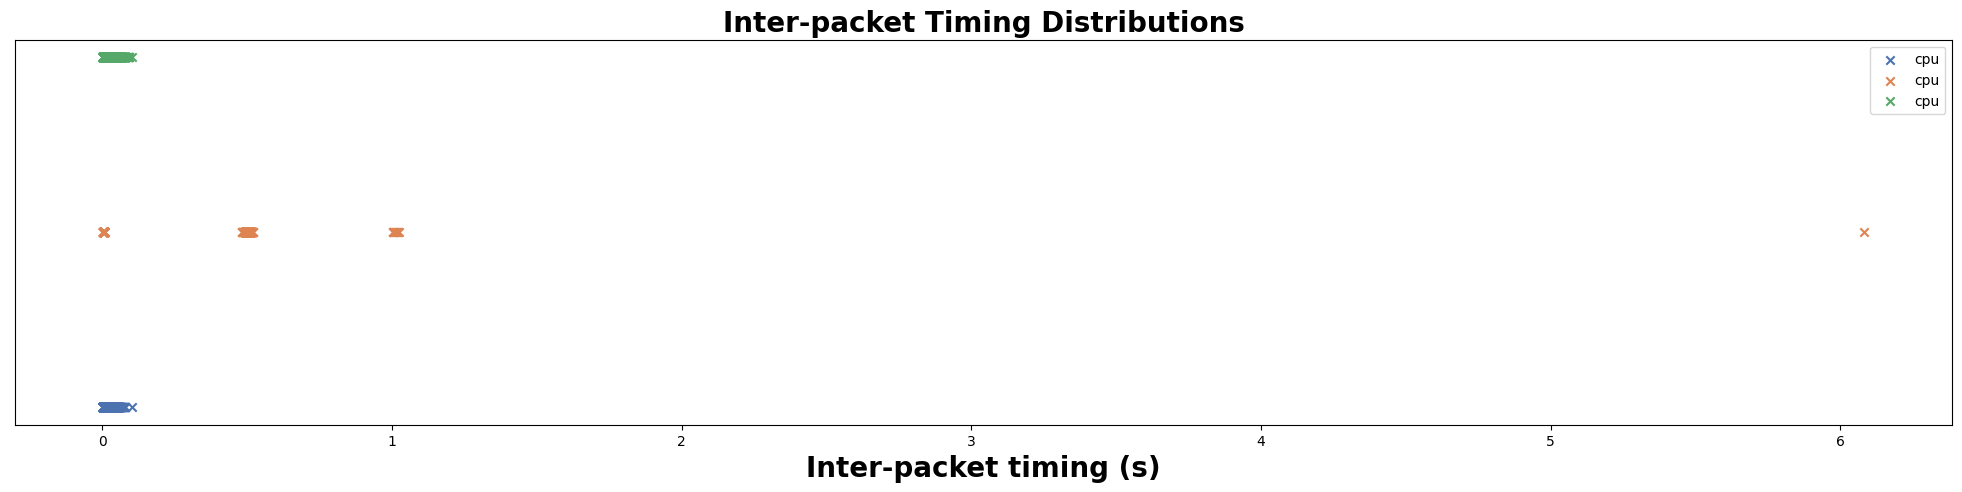

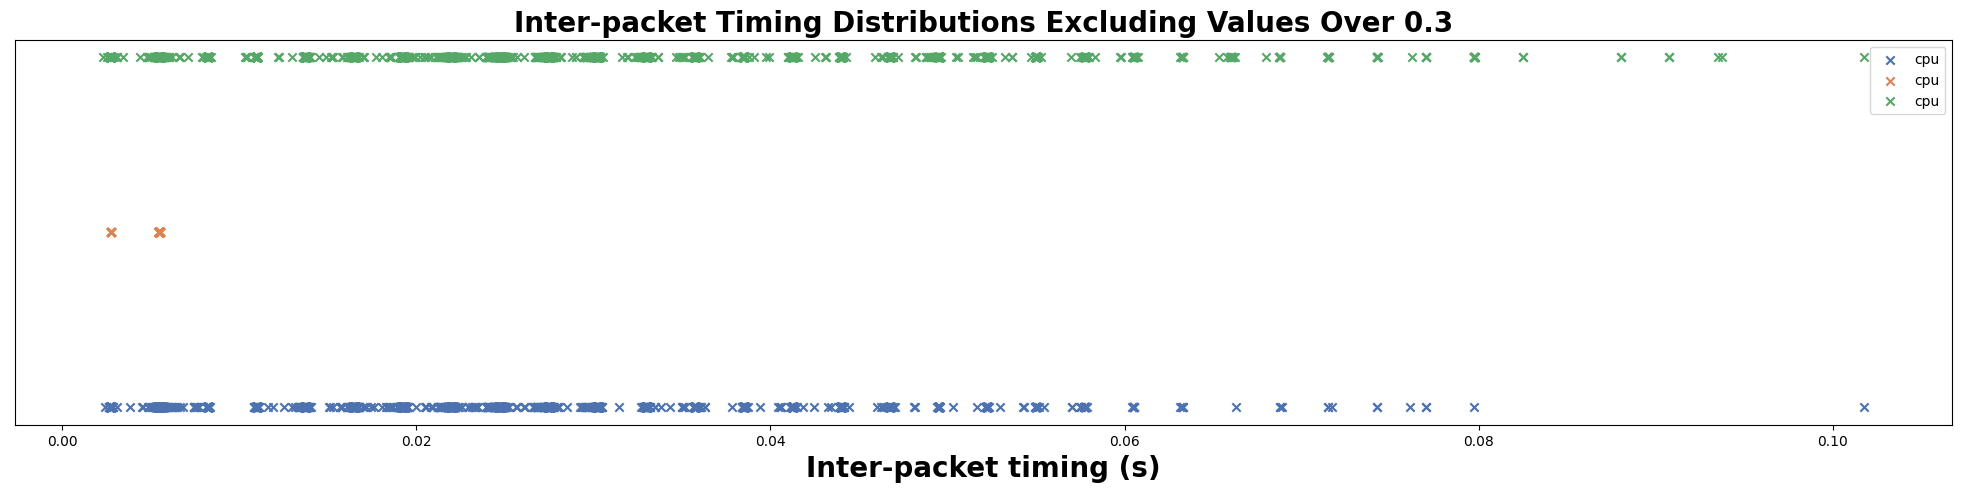

In [5]:
# Plot data distribution
plt.figure(figsize=(25,5))
legend = []
for i, d in enumerate(devices):
    vals = data_df.loc[data_df['Device'] == d]['Interpacket Timing'].values
    plt.scatter(vals, np.zeros_like(vals) + i/10, marker='x')
    plt.yticks([])
    legend.append(device)
plt.legend(legend)
plt.xlabel('Inter-packet timing (s)', fontweight='bold', fontsize=20)
plt.title('Inter-packet Timing Distributions', fontweight='bold', fontsize=20)
plt.savefig(os.path.join(FIGUREDIR, f'inter-packet_timing_distributions.png'))
plt.show()

# Plot data distribution without clear difference
plt.figure(figsize=(25,5))
legend = []
for i, d in enumerate(devices):
    vals = data_df.loc[(data_df['Device'] == d) & (data_df['Interpacket Timing'] < 0.3)]['Interpacket Timing'].values
    plt.scatter(vals, np.zeros_like(vals) + i, marker='x')
    plt.yticks([])
    legend.append(device)
plt.legend(legend)
plt.xlabel('Inter-packet timing (s)', fontweight='bold', fontsize=20)
plt.title('Inter-packet Timing Distributions Excluding Values Over 0.3', fontweight='bold', fontsize=20)
plt.savefig(os.path.join(FIGUREDIR, f'inter-packet_timing_distributions_sub_0.3.png'))
plt.show()

### 2.2 Prepare data for model training

In [6]:
class CustomDataset(Dataset):
    """
    Custom PyTorch Dataset 
    for time data.

    Attributes:
        data_array (array): NumPy array of data.
    """

    def __init__(self, data_array):
        self.data_array = data_array

    def __len__(self):
        return len(self.data_array)
    
    def __getitem__(self, idx):
        # Convert item to tensor
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Obtain sample and subject
        sample = self.data_array[idx]
        sample = torch.Tensor(sample)
        label = sample[-1]
        sample = sample[:-1]
        sample = torch.Tensor(sample)

        # Obtain label and encode
        label = onehot_encoder.transform([[label]])[0]

        return sample, label

In [7]:
# Split into training and test
[train_data, test_data] = train_test_split(data_df)

# Replace devices with numeric mapping
train_data.replace({'Device': devices}, inplace=True)
test_data.replace({'Device': devices}, inplace=True)

# Normalise data
train_temp_columns = train_data.iloc[:, -1]
test_temp_columns = test_data.iloc[:, -1]
train_data_norm = train_data.iloc[:, 0]
test_data_norm = test_data.iloc[:, 0]
train_data_norm = (train_data_norm-train_data_norm.mean())/train_data_norm.std()
test_data_norm = (test_data_norm-test_data_norm.mean())/test_data_norm.std()
train_data_norm = pd.concat([train_data_norm, train_temp_columns], axis=1)
test_data_norm = pd.concat([test_data_norm, test_temp_columns], axis=1)

In [8]:
# Check balance within the training dataset
counts = train_data_norm['Device'].value_counts()
for d, v in devices.items():
    print(f'Training samples from {d} - {counts[v]}')
print('')

# Balance data using over sampling
over_sampler = RandomOverSampler()
X_res, y_res = over_sampler.fit_resample(train_data_norm['Interpacket Timing'].values.reshape(-1, 1),
                                         train_data_norm['Device'].values)
train_data_norm_balanced = pd.DataFrame({'Interpacket Timing': np.squeeze(X_res),
                                         'Device': y_res})
    
# Check balance within the oversampled training dataset
counts = train_data_norm_balanced['Device'].value_counts()
for d, v in devices.items():
    print(f'Training samples from {d} after oversampling - {counts[v]}')
print('')

Training samples from ihealth_bpm - 5477
Training samples from viatom_wpo - 263
Training samples from vivachek_bgm - 4389

Training samples from ihealth_bpm after oversampling - 5477
Training samples from viatom_wpo after oversampling - 5477
Training samples from vivachek_bgm after oversampling - 5477



In [9]:
# Fit onehot encoder
onehot_encoder = OneHotEncoder(sparse_output=False)
train_labels = train_data_norm_balanced['Device'].values
train_labels = train_labels.reshape(len(train_labels), 1)
onehot_encoder.fit(train_labels)

# Print some statistics
print(f'Training data points: {train_data_norm_balanced.shape[0]}')
print(f'Test data points: {test_data_norm.shape[0]}')

Training data points: 16431
Test data points: 3377


In [10]:
# Create Datasets
train_dataset = CustomDataset(train_data_norm_balanced.to_numpy())
test_dataset = CustomDataset(test_data_norm.to_numpy())

# Create test DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=0)

## **3. Support Vector Machine (SVM)**

### 3.1 Define and fit model

In [11]:
# Create data arrays
X_train = train_data_norm_balanced['Interpacket Timing'].values
X_test = test_data_norm['Interpacket Timing'].values
y_train = train_data_norm_balanced['Device'].values
y_test = test_data_norm['Device'].values

# Create validation set
hpo_X_train, hpo_X_val, hpo_y_train, hpo_y_val = train_test_split(X_train, y_train)

# Create fold splitter
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True)

# Hyperparameter optimisation
print('Performing hyperparameter optimsation with k-fold cross validation...\n')
for c in np.logspace(-3, 3, 7):
    print(f'C value - {c}')

    # Loop over folds
    total_fold_accuracy = 0
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train,
                                                          y_train)):
        # Split data
        fold_X_train, fold_y_train = X_train[train_idx], y_train[train_idx]
        fold_X_val, fold_y_val = X_train[val_idx], y_train[val_idx]

        # Create an SVM classifier
        SVMClassifier = svm.SVC(kernel='rbf', C=c)

        # Train the classifier on the training data
        SVMClassifier.fit(fold_X_train.reshape(-1, 1), fold_y_train)

        # Test accuracy on validation data
        fold_y_pred = SVMClassifier.predict(fold_X_val.reshape(-1, 1))
        fold_accuracy = accuracy(fold_y_val, fold_y_pred)
        total_fold_accuracy += fold_accuracy

    # Average accuracy
    mean_fold_accuracy = total_fold_accuracy/K_FOLDS
    print(f'Mean accuracy on validation sets across {K_FOLDS} folds - {mean_fold_accuracy:.2f}%\n')

Performing hyperparameter optimsation with k-fold cross validation...

C value - 0.001
Mean accuracy on validation sets across 5 folds - 56.47%

C value - 0.01
Mean accuracy on validation sets across 5 folds - 56.40%

C value - 0.1
Mean accuracy on validation sets across 5 folds - 57.91%

C value - 1.0
Mean accuracy on validation sets across 5 folds - 60.45%

C value - 10.0
Mean accuracy on validation sets across 5 folds - 60.94%

C value - 100.0
Mean accuracy on validation sets across 5 folds - 60.93%

C value - 1000.0
Mean accuracy on validation sets across 5 folds - 60.83%



As larger values of C can lead to overfitting, and do not provide large increases in model accuracy, a value of C=1 will be used for the final model.

In [12]:
# Create an SVM classifier
FinalSVMClassifier = svm.SVC(kernel='rbf', C=1)

# Train the classifier on the training data
FinalSVMClassifier.fit(X_train.reshape(-1, 1), y_train)

SVC(C=1)

### 3.2 Evaluate model

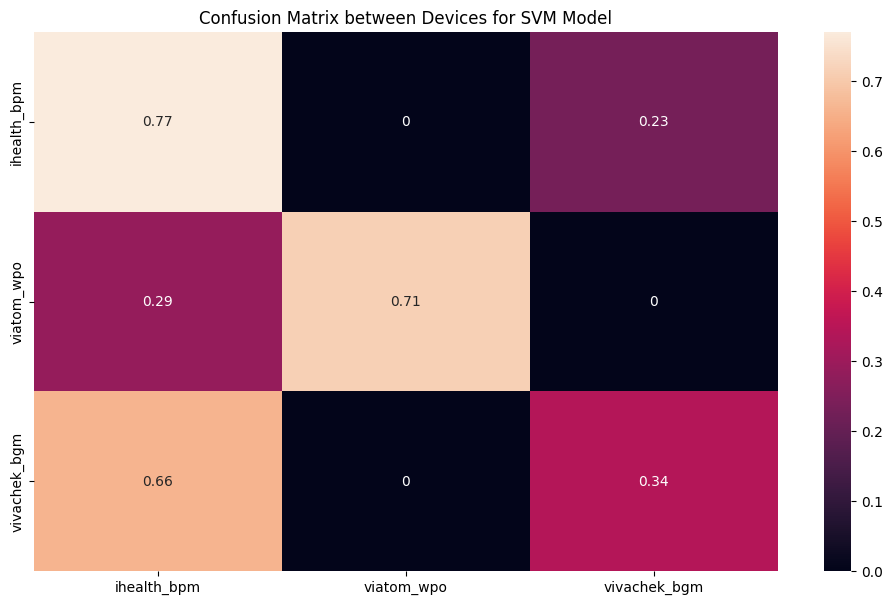

Performance Metrics for SVM Model:


,ihealth_bpm,viatom_wpo,vivachek_bgm
Precision,0.59,1.00,0.54
Recall,0.77,0.71,0.34
F1 Score,0.67,0.83,0.42


SVM Model accuracy on test set: 58.28%


In [14]:
# Make predictions on the test set
svm_y_pred = FinalSVMClassifier.predict(X_test.reshape(-1, 1))

# Calculate performance metrics
y_true = y_test
svm_accuracy, performance_df = calculate_metrics(y_true, svm_y_pred, model='SVM')
print('Performance Metrics for SVM Model:')
display(performance_df)
print(f'SVM Model accuracy on test set: {svm_accuracy:.2f}%')

## **4. Logistic regression**

### 4.1 Define model

In [19]:
# Logisitc regression model
class LogisticRegression(nn.Module):
    def __init__(self, in_features, out_labels):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(in_features, out_labels)

    def forward(self, x):
        outputs = F.softmax(self.linear(x), dim=2)
        return outputs

# Model structure
DeviceClassifier = LogisticRegression(in_features=N_FEATURES, out_labels=N_LABELS).to(device)
params = sum(p.numel() for p in DeviceClassifier.parameters() if p.requires_grad)
print("Total number of parameters for the classifier: {}\n".format(params))
print("Classifier architecture:")
print(DeviceClassifier)

Total number of parameters for the classifier: 6

Classifier architecture:
LogisticRegression(
  (linear): Linear(in_features=1, out_features=3, bias=True)
)


### 4.2 Train model

Beginning training

Fold 1/5


  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

Loss curve:


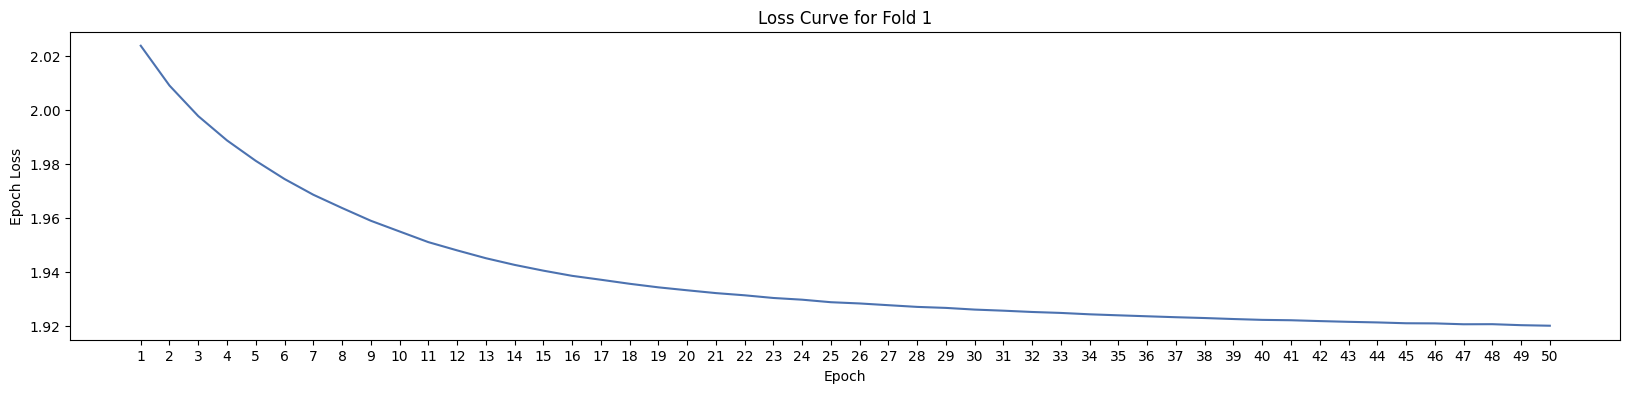

Accuracy on validation set 60.88%

Fold 2/5


  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

Loss curve:


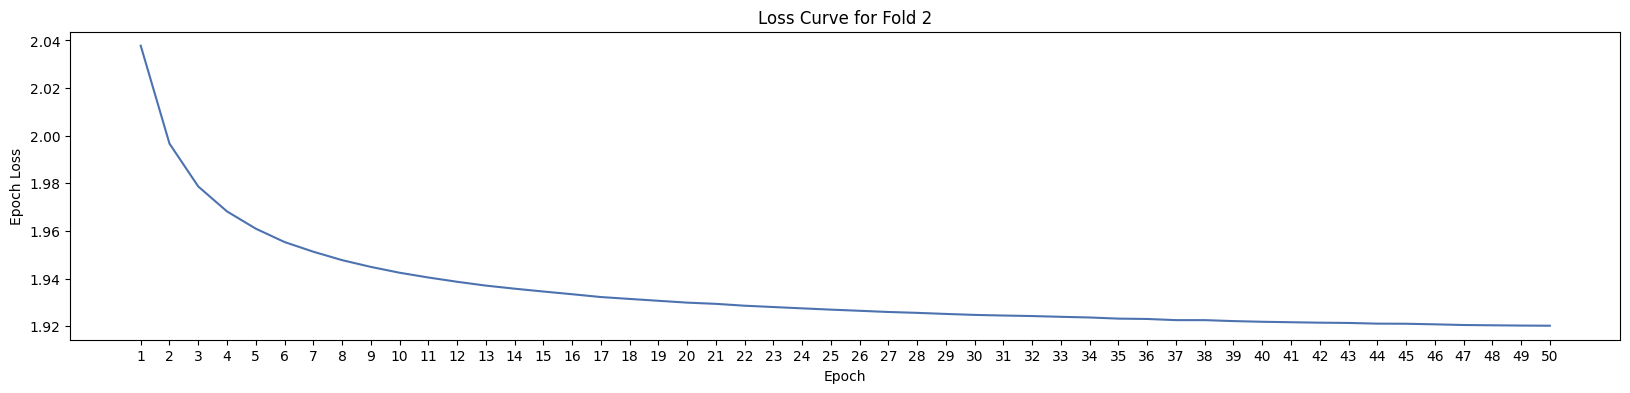

Accuracy on validation set 60.59%

Fold 3/5


  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

Loss curve:


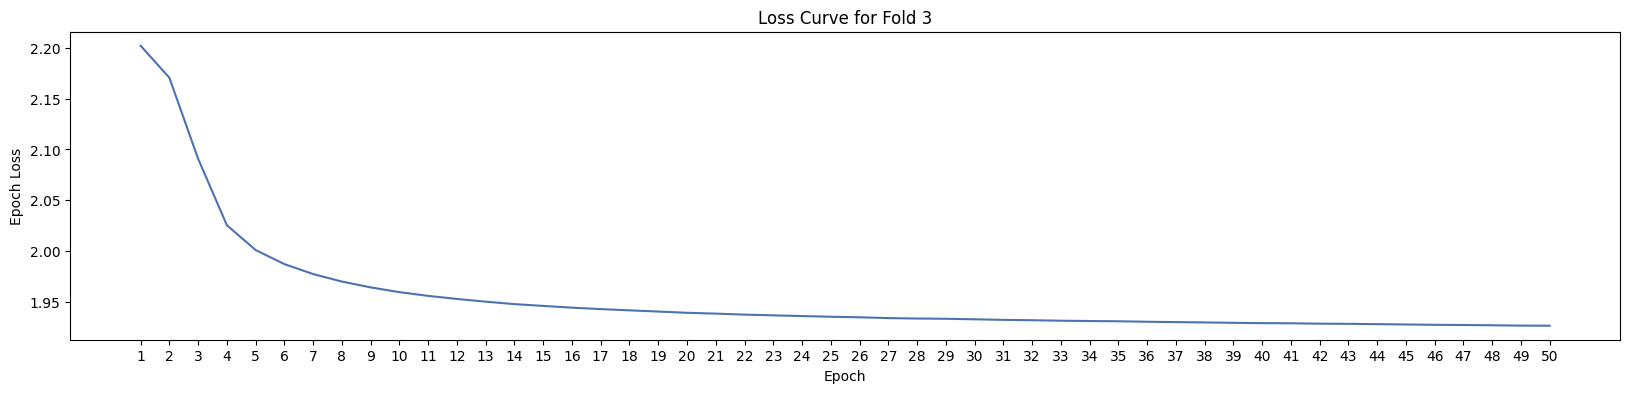

Accuracy on validation set 60.01%

Fold 4/5


  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

Loss curve:


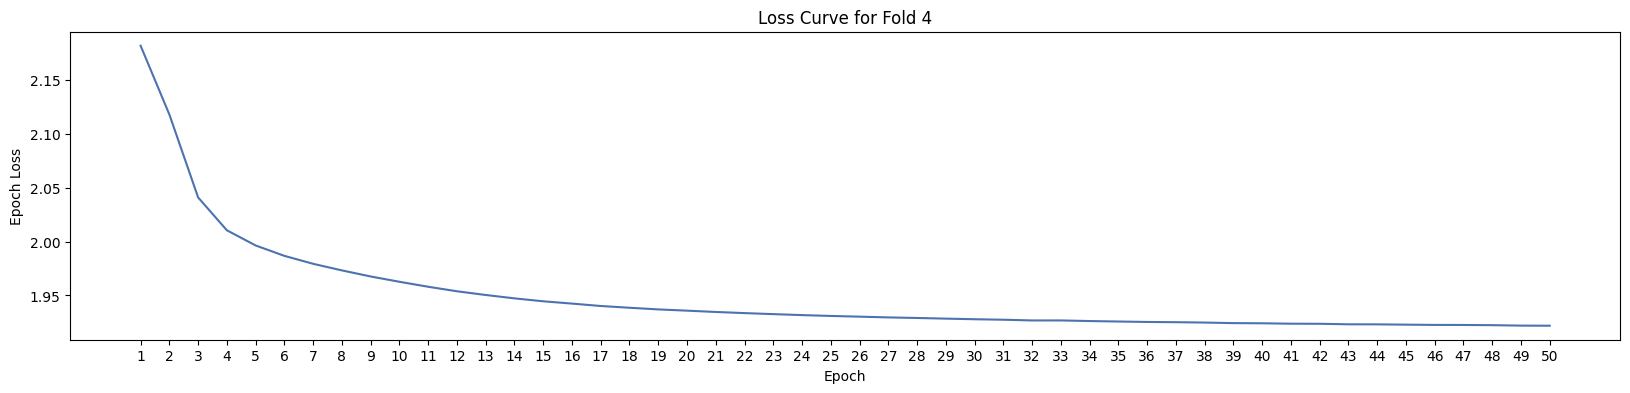

Accuracy on validation set 61.26%

Fold 5/5


  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

  0%|          | 0/103 [00:00<?, ?batch/s]

Loss curve:


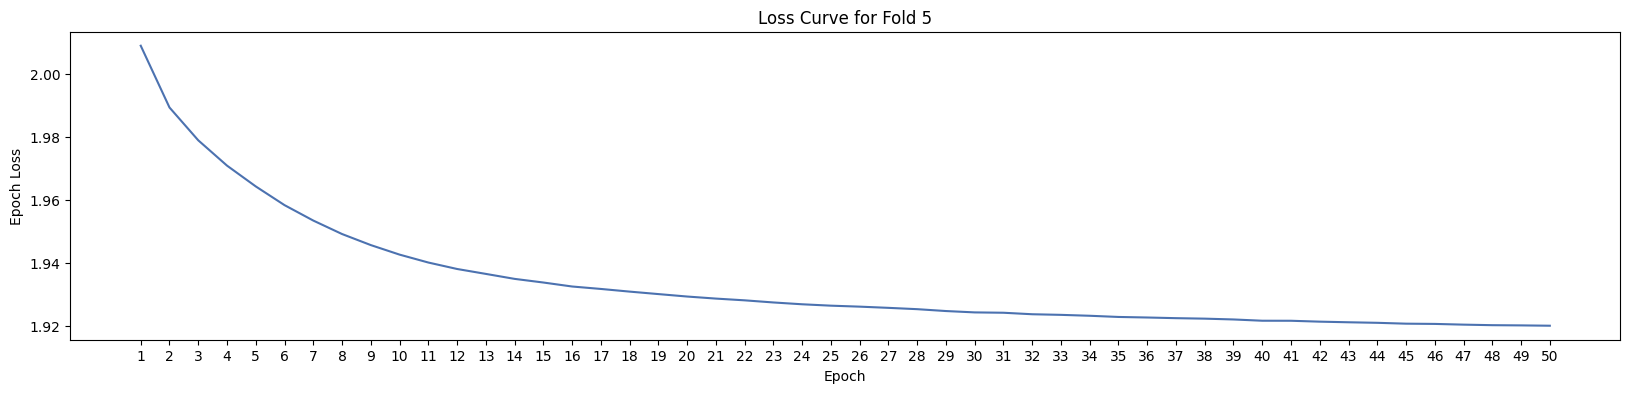

Accuracy on validation set 60.74%


<All keys matched successfully>

In [22]:
# Initiliase model weights container and lowest loss
model_params = []
lowest_loss = np.inf

# Loop over K-Folds
print('Beginning training')
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data_norm_balanced['Interpacket Timing'].to_numpy(),
                                                      train_data_norm_balanced['Device'].to_numpy())):
    print(f'\nFold {fold + 1}/{K_FOLDS}')
    
    # Create data loaders for the current fold
    train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=BATCH_SIZE, 
                                  sampler=torch.utils.data.SubsetRandomSampler(train_idx))
    val_dataloader = DataLoader(dataset=train_dataset, 
                                batch_size=BATCH_SIZE, 
                                sampler=torch.utils.data.SubsetRandomSampler(val_idx))

    # Initialise model
    DeviceClassifier = LogisticRegression(in_features=N_FEATURES, 
                                          out_labels=N_LABELS).to(device)
    DeviceClassifier.train()
    optimizer = torch.optim.Adam(DeviceClassifier.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    total_loss = []

    # Loop over epochs
    for epoch in range(N_EPOCHS):
        # Running loss container
        running_loss = 0.0

        # Loop over batches
        with tqdm(train_dataloader, unit="batch") as tepoch: 
            for batch_idx, (data, label) in enumerate(tepoch):

              # Batch tensor and add channel dimension
              batch_tensor = data.to(device)
              label = label.to(device)
              batch_tensor = batch_tensor[:, None, :]

              # Compute reconstructions
              results = DeviceClassifier(batch_tensor)
              results = results.squeeze()
              
              # Loss
              loss = criterion(results, label)

              # Backpropagation based on the loss
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

              # Update loss
              running_loss += loss.item()

              # Log
              if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch+1}")
                tepoch.set_postfix(loss=loss.item())

            # Average epoch loss
            total_loss.append(running_loss/batch_idx+1)

            # Check if epoch loss is lowest seen
            if total_loss[-1] < lowest_loss:
              best_model_params = DeviceClassifier.state_dict()
              lowest_loss = total_loss[-1]
        
    # Plot loss curve
    print('Loss curve:')
    loss_curve(total_loss, fold+1)

    # Save model parameters and reload best model
    model_params.append(best_model_params)
    DeviceClassifier.load_state_dict(best_model_params)

    # Test on validation set
    val_true = []
    val_pred = []
    DeviceClassifier.eval()
    with torch.no_grad():
      for data, labels in val_dataloader:
        # Batch tensor and add channel dimension
        batch_tensor = data.to(device)
        labels = labels.to(device)
        batch_tensor = batch_tensor[:, None, :]

        # Obtain model predictions
        results = DeviceClassifier(batch_tensor)
        results = results.squeeze()

        # Save predictions
        output = (torch.max(torch.exp(results), 1)[1]).data.cpu().numpy()
        val_pred.extend(output)

        # Unencode labels and save
        labels = onehot_encoder.inverse_transform(labels.cpu().numpy())
        labels = np.array([x[0] for x in labels])
        val_true.extend(labels)
        
    # Validation accuracy metrics
    val_pred = np.array(val_pred)
    val_true = np.array(val_true)
    fold_accuracy = accuracy(val_true, val_pred)
    print(f'Accuracy on validation set {fold_accuracy:.2f}%')

# Create final model from average
average_params = {}
for param in model_params[0]:
    average_params[param] = torch.stack([params[param] for params in model_params], dim=0).mean(dim=0)

# Create a new model with the averaged parameters
FinalDeviceClassifier = LogisticRegression(in_features=N_FEATURES, 
                                           out_labels=N_LABELS).to(device)
FinalDeviceClassifier.load_state_dict(average_params)

### 4.3 Evaluate model

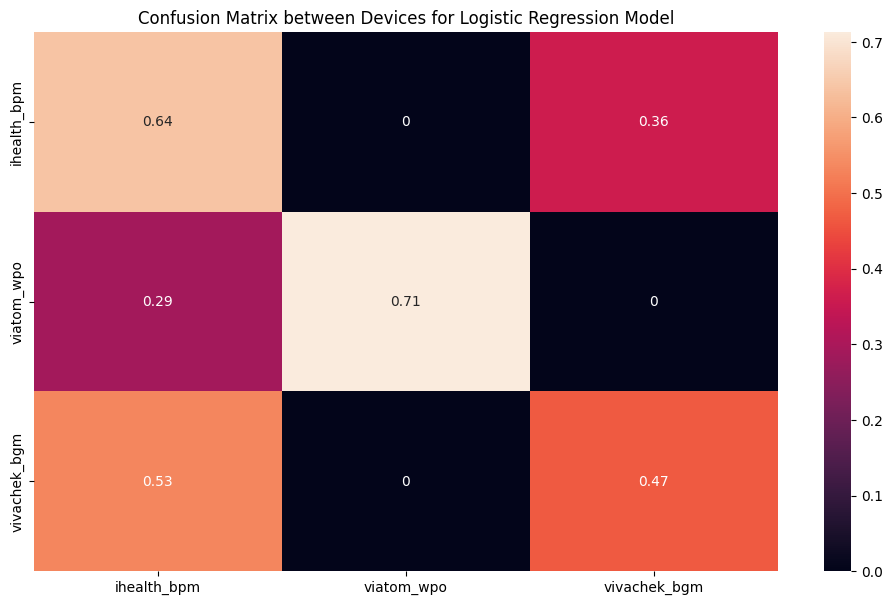

Performance Metrics for Logistic Regression Model:


,ihealth_bpm,viatom_wpo,vivachek_bgm
Precision,0.59,1.00,0.51
Recall,0.64,0.71,0.47
F1 Score,0.61,0.83,0.49


Logistic Regression Model accuracy on test set: 56.71%


In [23]:
# Containers for predictions
log_y_pred = []
y_true = []

# Put model in evaluation mode
FinalDeviceClassifier.eval()
torch.no_grad()

# Loop over test batches
for data, labels in test_dataloader:
    # Batch tensor and add channel dimension
    batch_tensor = data.to(device)
    labels = labels.to(device)
    batch_tensor = batch_tensor[:, None, :]

    # Obtain model predictions
    results = FinalDeviceClassifier(batch_tensor)
    results = results.squeeze()

    # Save predictions
    output = (torch.max(torch.exp(results), 1)[1]).data.cpu().numpy()
    log_y_pred.extend(output)

    # Unencode labels and save
    labels = onehot_encoder.inverse_transform(labels.cpu().numpy())
    labels = np.array([x[0] for x in labels])
    y_true.extend(labels)

# Calculate performance metrics
log_y_pred = np.array(log_y_pred)
y_true = np.array(y_true)
lr_accuracy, performance_df = calculate_metrics(y_true, log_y_pred, model='Logistic Regression')
print('Performance Metrics for Logistic Regression Model:')
display(performance_df)
print(f'Logistic Regression Model accuracy on test set: {lr_accuracy:.2f}%')